<a href="https://colab.research.google.com/github/dlckdtn62/BIO-PREDICTION/blob/master/bio_basic_0519.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 현재 kfold까지해서 좋은 결과발생

# 앞으로의 방향
Feature Engineering이 필요한 상황
스펙트럼 파장의 길이 값이므로
진폭, 주기 진동수 등을 생각해보고
이들간의 계산이 어떻게 들어가는지도 추가

http://www.ktword.co.kr/abbr_view.php?id=5&m_temp1=1898


In [0]:
import pandas as pd
import numpy as np
import lightgbm as lgbm

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
path = "/content/drive/My Drive/dacon/bio/"

In [0]:
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
sample_submission = pd.read_csv(path+'sample_submission.csv')

In [0]:
"""
id : 구분자
rho : 측정 거리 (단위: mm)
src : 광원 스펙트럼 (650 nm ~ 990 nm)
dst : 측정 스펙트럼 (650 nm ~ 990 nm)
hhb : 디옥시헤모글로빈 농도
hbo2 : 옥시헤모글로빈 농도
ca : 칼슘 농도
na : 나트륨 농도
"""

'\nid : 구분자\nrho : 측정 거리 (단위: mm)\nsrc : 광원 스펙트럼 (650 nm ~ 990 nm)\ndst : 측정 스펙트럼 (650 nm ~ 990 nm)\nhhb : 디옥시헤모글로빈 농도\nhbo2 : 옥시헤모글로빈 농도\nca : 칼슘 농도\nna : 나트륨 농도\n'

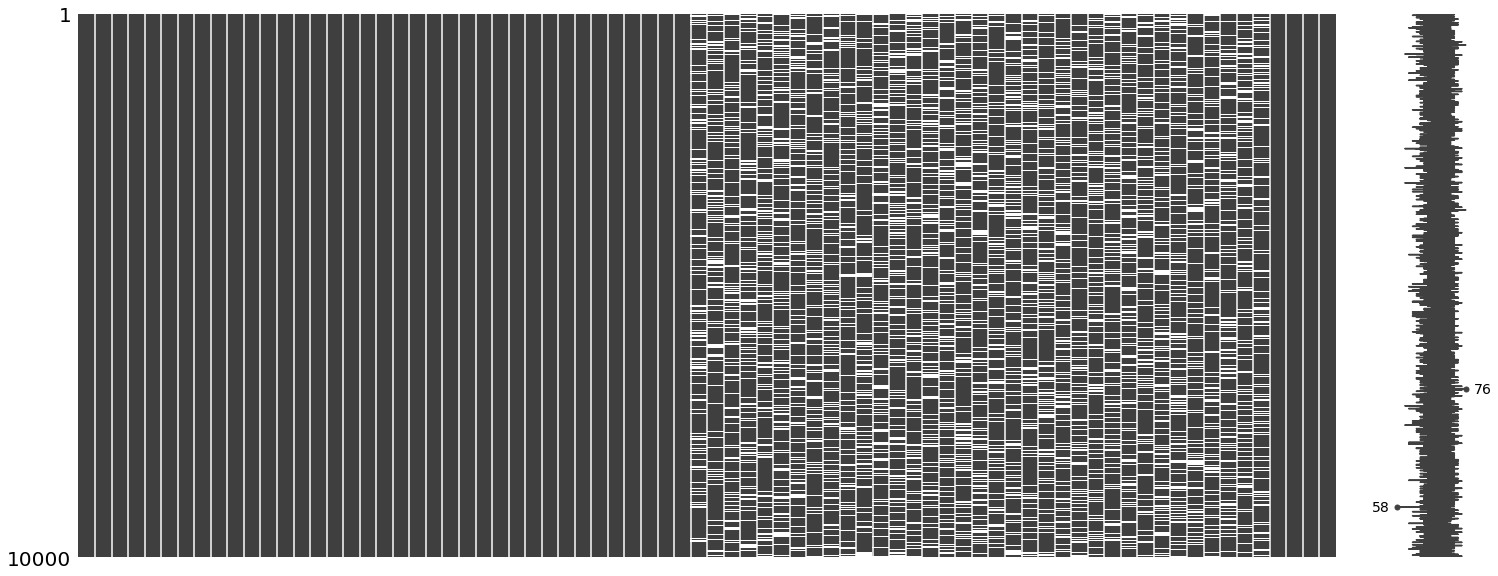

In [0]:
import missingno as msno
msno.matrix(train)

In [0]:
train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,1.098559e-17,8.907142e-19,NaN,0.000000e+00,NaN,0.000000e+00,5.901745e-18,NaN,1.176812e-18,NaN,5.557492e-17,1.046498e-16,NaN,7.236748e-17,4.021610e-17,2.397489e-17,1.870153e-17,1.808920e-17,NaN,0.000000e+00,2.626216e-18,NaN,3.527371e-18,NaN,6.455564e-19,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,1.151021e-10,4.318673e-10,2.753933e-10,0.000000e+00,8.138830e-10,6.522110e-10,NaN,2.732232e-10,NaN,7.663267e-11,NaN,1.389496e-10,1.472282e-09,1.450463e-09,1.225321e-09,2.647633e-09,NaN,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,0.000000e+00,NaN,NaN,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,3.349335e-19,NaN,0.000000e+00,2.630961e-18,NaN,0.000000e+00,9.912979e-18,1.112747e-17,NaN,NaN,NaN,1.260239e-19,NaN,0.000000e+00,3.876159e-18,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,NaN,1.583839e-10,NaN,1.678049e-10,2.814419e-10,4.429321e-10,1.319956e-09,2.269806e-09,2.679164e-09,2.538200e-09,2.046841e-09,1.516820e-09,1.328007e-09,1.061359e-09,8.634016e-10,5.804951e-10,3.615067e-10,NaN,1.274876e-10,6.118947e-11,NaN,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.01455,0.98861,0.98300,1.00616,0.99045,1.01321,1.01559,1.01072,0.99439,0.98597,0.99889,1.01412,4.784751e-14,NaN,0.000000e+00,1.153089e-13,0.000000e+00,0.000000e+00,1.056991e-13,0.000000e+00,0.000000e+00,2.666663e-14,1.493071e-14,NaN,0.000000e+00,1.200730e-13,2.648249e-13,NaN,4.392331e-13,2.831191e-13,4.557059e-13,1.326038e-13,1.864796e-13,1.419359e-13,1.765559e-13,1.593789e-13,NaN,0.000000e+00,NaN,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN,11.9

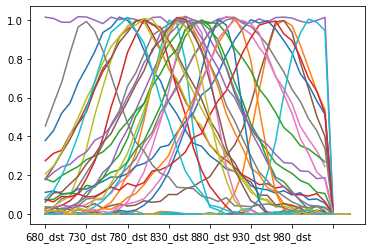

In [0]:
for i in range(30):
    train.iloc[i,2:40].plot()
for i in range(50):
    train.iloc[i,40:-4].plot()

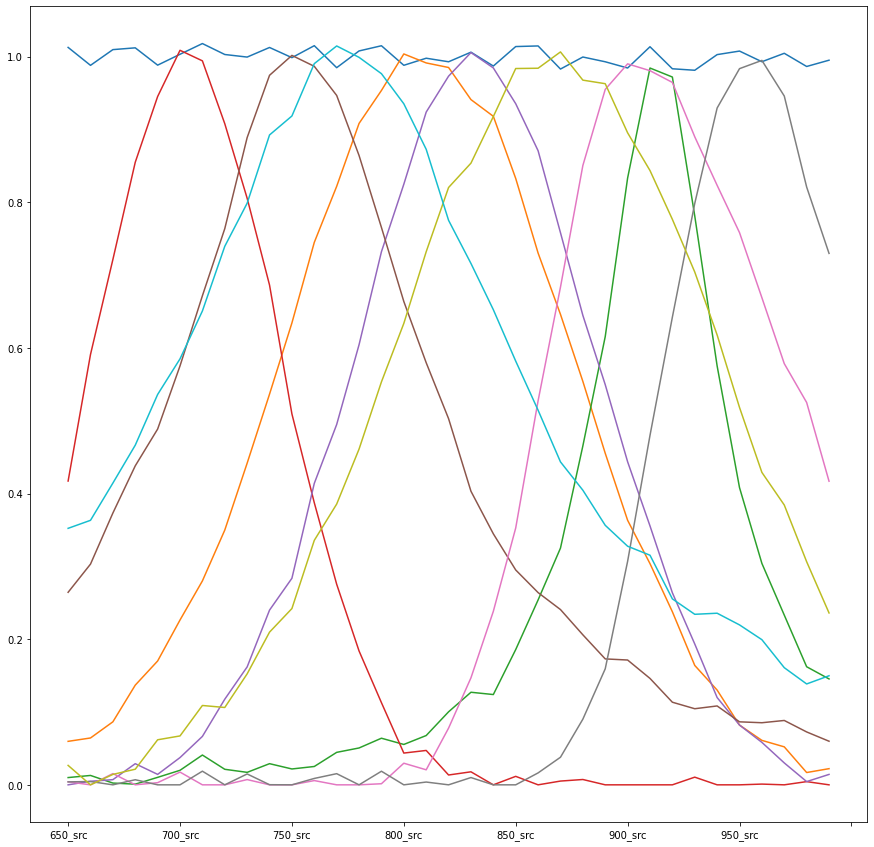

In [0]:
for i in range(10):
    train[train.rho == 10].iloc[i+30,2:2+35].plot(figsize=(15,15))
    # plt.show()

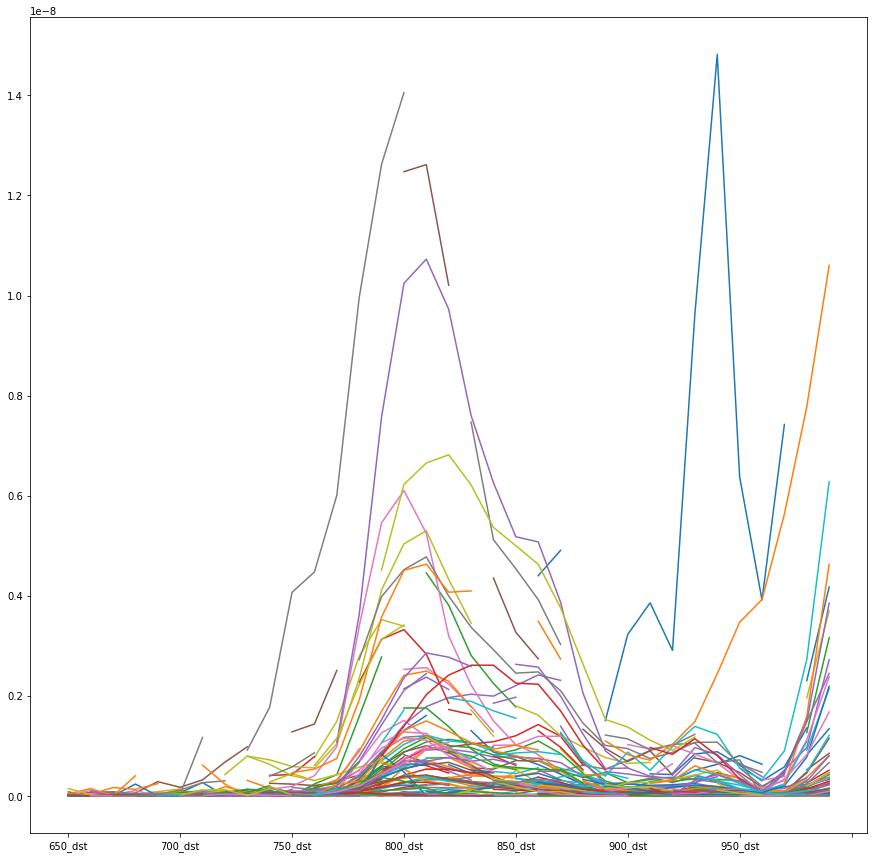

In [0]:
for i in range(100):
    test[test.rho == 10].iloc[i+50,2+35:2+35+35].plot(figsize=(15,15))
    # plt.show()

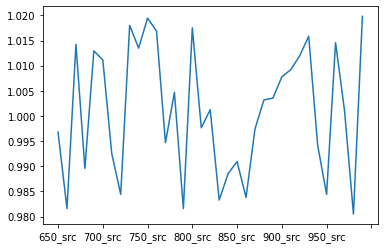

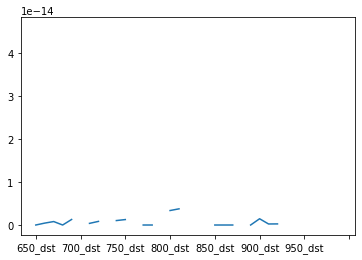

In [0]:
i=200
train.filter(regex='src').iloc[i].plot()
plt.show()

train.filter(regex='dst').iloc[i].plot()

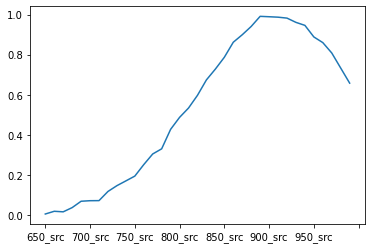

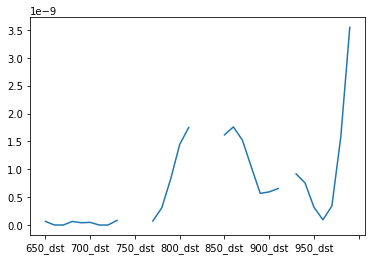

In [0]:
rho10 = train[train['rho']==10]
i=100
rho10.filter(regex='src').iloc[i].plot()
plt.show()

rho10.filter(regex='dst').iloc[i].plot()

In [0]:
train.iloc[5000:5001]

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
5000,5000,15,0.45956,0.51888,0.56975,0.66418,0.73822,0.82678,0.90722,0.9393,1.01025,0.98702,0.97253,0.91447,0.85134,0.79325,0.71057,0.64444,0.56565,0.4892,0.45583,0.38014,0.32687,0.30371,0.28591,0.25746,0.21402,0.18467,0.17294,0.15774,0.14849,0.15721,0.12215,0.13421,0.10722,0.10981,0.09499,NaN,2.210704e-14,1.956075e-14,3.583311e-14,0.0,5.831913e-14,8.941214e-14,2.163051e-15,0.0,1.060226e-13,1.575558e-14,NaN,8.892919e-14,3.383112e-13,1.185761e-12,1.873997e-12,1.849502e-12,1.297897e-12,9.144567e-13,6.096957e-13,4.478430e-13,3.628347e-13,3.400740e-13,1.461900e-13,6.791808e-14,2.788370e-14,NaN,1.656313e-14,NaN,1.019711e-13,3.949172e-14,2.017155e-14,7.849003e-14,2.451064e-13,8.387024e-13,7.2,4.72,9.96,4.02


In [0]:
train_2 = train.copy()
train_2[train_2.filter(regex='990').columns] = train_2[train_2.filter(regex='990').columns].fillna(0)
trainTransform = train_2.T.fillna(method='bfill').T
test_2 = test.copy()
test_2[test_2.filter(regex='990').columns] = test_2[test_2.filter(regex='990').columns].fillna(0)
testTransform = test_2.T.fillna(method='bfill').T

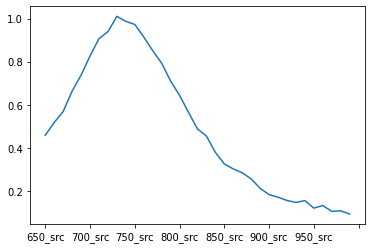

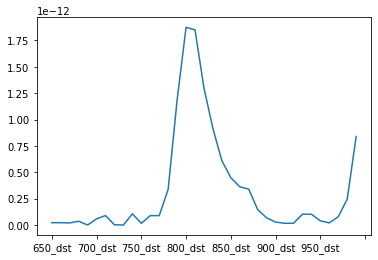

In [0]:
i=5000
trainTransform.filter(regex='src').iloc[i].plot()
plt.show()

trainTransform.filter(regex='dst').iloc[i].plot()

In [0]:
trainTransform.head(1)
trainTransform.filter(regex='dst').T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
650_dst,2.447758e-18,0.000000e+00,1.677445e-19,4.044975e-11,4.784751e-14,0.000000e+00,0.000000e+00,0.000000e+00,6.847028e-17,2.723855e-20,4.073736e-22,0.000000e+00,3.282509e-14,2.468582e-12,0.000000e+00,7.210768e-17,1.471178e-19,9.696022e-14,0.000000e+00,0.000000e+00,1.134285e-19,3.091025e-20,3.230614e-11,1.056062e-12,0.000000e+00,2.697818e-19,1.231161e-19,8.083862e-19,0.000000e+00,0.000000e+00,0.000000e+00,1.222045e-12,2.395555e-17,3.788086e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.270996e-19,7.358321e-16,5.770257e-11,1.210934e-18,6.188627e-15,0.000000e+00,8.532628e-13,0.000000e+00,2.351780e-19,4.168293e-12,0.000000e+00,1.129091e-17,1.244581e-13,0.000000e+00,0.000000e+00,7.019335e-17,0.000000e+00,4.168110e-19,4.430407e-14,5.619065e-16,2.299411e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.863896e-19,0.000000e+00,9.894366e-21,9.852483e-11,3.336028e-16,3.213054e-15,4.742603e-12,1.320794e-11,0.000000e+00,8.566442e-12,2.728013e-15,3.021131e-17,7.248393e-12,1.629438e-13,2.188296e-11
660_dst,1.894578e-18,0.000000e+00,3.763590e-20,5.345363e-11,0.000000e+00,0.000000e+00,0.000000e+00,2.331678e-18,6.847028e-17,3.795126e-19,0.000000e+00,2.689306e-18,1.062954e-15,3.794609e-12,0.000000e+00,7.780380e-17,4.290674e-22,7.953117e-14,0.000000e+00,0.000000e+00,1.134285e-19,1.134378e-20,3.230614e-11,0.000000e+00,1.747659e-13,6.292865e-19,4.480027e-19,5.776820e-19,6.511134e-14,0.000000e+00,0.000000e+00,0.000000e+00,2.395555e-17,5.889765e-19,0.000000e+00,0.000000e+00,3.758999e-17,2.538537e-12,0.000000e+00,0.000000e+00,...,2.270996e-19,0.000000e+00,0.000000e+00,6.539187e-19,6.188627e-15,0.000000e+00,0.000000e+00,2.382238e-12,6.534872e-20,0.000000e+00,0.000000e+00,1.321294e-17,1.138011e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.350084e-19,0.000000e+00,0.000000e+00,1.230155e-11,0.000000e+00,3.183581e-17,3.053661e-11,0.000000e+00,8.802314e-19,0.000000e+00,2.987216e-21,6.498185e-12,0.000000e+00,1.889029e-15,1.121373e-11,7.024204e-13,0.000000e+00,8.566442e-12,1.438586e-14,3.021131e-17,0.000000e+00,1.531261e-14,0.000000e+00
670_dst,0.000000e+00,0.000000e+00,0.000000e+00,5.345363e-11,0.000000e+00,0.000000e+00,1.808480e-17,0.000000e+00,1.477517e-15,3.496313e-19,0.000000e+00,4.540026e-18,0.000000e+00,3.794609e-12,0.000000e+00,7.780380e-17,0.000000e+00,7.953117e-14,0.000000e+00,4.320040e-17,0.000000e+00,1.134378e-20,0.000000e+00,0.000000e+00,0.000000e+00,6.478533e-19,0.000000e+00,5.469629e-19,0.000000e+00,0.000000e+00,2.085126e-18,0.000000e+00,1.046729e-16,0.000000e+00,2.346100e-11,0.000000e+00,6.415248e-17,0.000000e+00,7.322156e-20,0.000000e+00,...,2.270996e-19,5.303196e-16,0.000000e+00,1.266893e-18,1.713128e-15,4.560651e-18,0.000000e+00,2.382238e-12,1.750602e-19,1.379808e-11,0.000000e+00,8.605261e-18,1.138011e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.039197e-19,1.179836e-14,0.000000e+00,1.880725e-11,3.208940e-11,4.318401e-18,2.507099e-11,5.197267e-13,0.000000e+00,0.000000e+00,0.000000e+00,7.036575e-11,0.000000e+00,6.590359e-15,7.687178e-14,1.785193e-11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.125747e-11,1.531261e-14,2.737677e-11
680_dst,6.412913e-18,1.995530e-10,0.000000e+00,9.106886e-12,1.153089e-13,0.000000e+00,1.808480e-17,2.714917e-18,1.396963e-15,3.496313e-19,6.999389e-20,0.000000e+00,2.158986e-14,1.973622e-12,0.000000e+00,6.983940e-17,0.000000e+00,4.885190e-14,0.000000e+00,0.000000e+00,0.000000e+00,8.531152e-21,0.000000e+00,0.000000e+00,6.663792e-14,1.436545e-19,0.000000e+00,5.469629e-19,2.066481e-13,3.264963e-11,0.000000e+00,0.000000e+00,1.046729e-16,4.162288e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.188355e-20,7.081251e-11,.

#푸리에 변환 나중에 시도해보기

In [0]:
pip install dfply

     |████████████████████████████████| 614kB 5.1MB/s 


In [0]:
import os
import numpy as np
import pandas as pd
from dfply import *
import seaborn as sns
import matplotlib
from matplotlib import gridspec
import matplotlib.dates as md
import matplotlib.pyplot as plt
from datetime import datetime

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


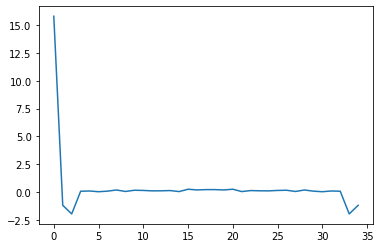

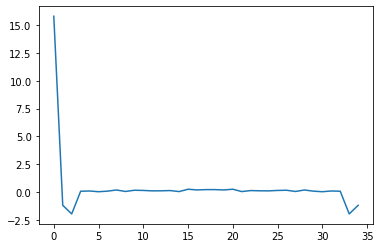

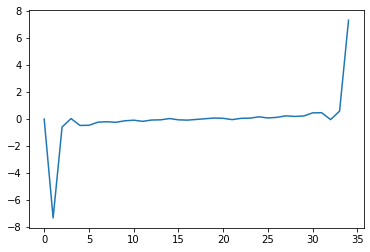

35
35


In [0]:
fft_value = np.fft.fft(trainTransform.filter(regex='src').T[0])
pd.Series(fft_value).plot()
plt.show()
pd.Series(fft_value.real).plot()
plt.show()
pd.Series(fft_value.imag).plot()
plt.show()
print(len(fft_value.real))
print(len(fft_value.imag))

In [0]:
train_2 = train.copy()
train_2[train_2.filter(regex='990').columns] = train_2[train_2.filter(regex='990').columns].fillna(0)
trainTransform = train_2.T.fillna(method='bfill').T
test_2 = test.copy()
test_2[test_2.filter(regex='990').columns] = test_2[test_2.filter(regex='990').columns].fillna(0)
testTransform = test_2.T.fillna(method='bfill').T

In [0]:
def add_FFT_columns(df, regex='src'):
    src_df = df.filter(regex=regex)
    fft = np.fft.fft(src_df.T)
    
    real = pd.DataFrame(fft.real).T
    imag = pd.DataFrame(fft.imag).T

    real.columns = src_df.columns + '_freq_real'
    imag.columns = src_df.columns + '_freq_imag'

    added_df = pd.concat([df, real, imag], axis=1)

    return added_df

In [0]:
train_df = add_FFT_columns(trainTransform, 'src')
train_df = add_FFT_columns(train_df, regex= 'dst')

test_df = add_FFT_columns(testTransform, 'src')
test_df = add_FFT_columns(test_df, regex='dst')

650_src_freq_real    -8.880534
660_src_freq_real    -9.049339
670_src_freq_real    -9.861567
680_src_freq_real   -11.012265
690_src_freq_real    -9.633702
700_src_freq_real    -5.650306
710_src_freq_real    -0.395951
720_src_freq_real     0.939285
730_src_freq_real     2.213092
740_src_freq_real     1.296265
750_src_freq_real    -2.607517
760_src_freq_real    -5.927958
770_src_freq_real   -10.021532
780_src_freq_real   -12.763838
790_src_freq_real   -21.056154
800_src_freq_real   -23.150367
810_src_freq_real   -22.686415
820_src_freq_real   -19.928623
830_src_freq_real   -14.115980
840_src_freq_real    -4.702844
850_src_freq_real     5.208208
860_src_freq_real    15.645650
870_src_freq_real    24.293758
880_src_freq_real    27.913606
890_src_freq_real    29.646167
900_src_freq_real    26.061937
910_src_freq_real    21.398097
920_src_freq_real    16.144303
930_src_freq_real     7.283178
940_src_freq_real    -1.477448
950_src_freq_real    -6.599286
960_src_freq_real    -8.335803
970_src_

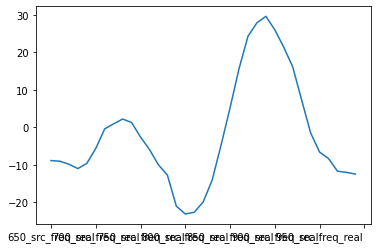

In [0]:
# i=5000
# train_df.filter(regex='src_freq').iloc[i].plot()
# plt.show()
# train_df.filter(regex='dst_freq').iloc[i].plot()
train_df.head(1)

x=100
i = 2+35+39
train_df.iloc[x,i:i+35].plot()
train_df.iloc[x,i:i+35]

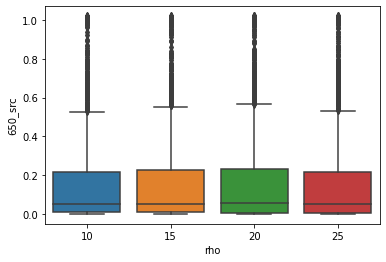

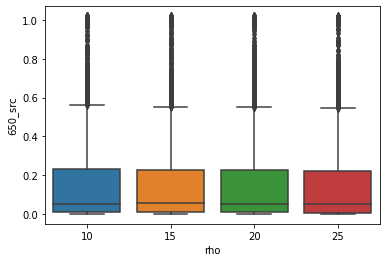

In [0]:
sns.boxplot(data=train, x='rho', y='650_src')
plt.show()
sns.boxplot(data=test, x='rho', y='650_src')
plt.show()

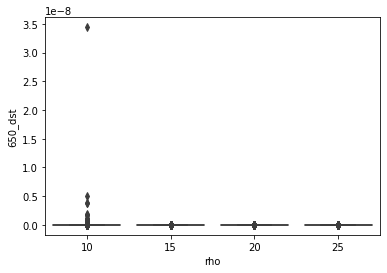

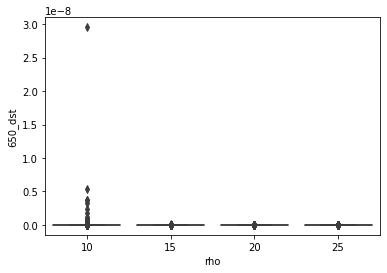

In [0]:
sns.boxplot(data=train, x='rho', y='650_dst')
plt.show()
sns.boxplot(data=test, x='rho', y='650_dst')
plt.show()

In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from lightgbm import LGBMRegressor,  plot_importance
import lightgbm as lgbm

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [0]:
train_src = train.filter(regex='src')
for col in train_src.columns:
    plt.figure(figsize=(50,3))
    plt.plot(train_src[col])
    plt.show()

In [0]:
train_dst = train.filter(regex='dst')
for col in train_dst.columns:
    plt.figure(figsize=(50,3))
    plt.plot(train_dst[col])
    plt.show()

In [0]:
test_dst = test.filter(regex='dst')
for col in test_dst.columns:
    plt.figure(figsize=(50,3))
    plt.plot(test_dst[col])
    plt.show()

In [0]:
for col in train_dst:
    sns.boxplot(data=train, x='rho', y=col)
    plt.show()

In [0]:
# i = 0
# train.iloc[i,:][train.iloc[i,:].isnull()==True]

710_dst   NaN
730_dst   NaN
760_dst   NaN
780_dst   NaN
810_dst   NaN
870_dst   NaN
900_dst   NaN
920_dst   NaN
940_dst   NaN
960_dst   NaN
Name: 0, dtype: float64

In [0]:
# yData = train.iloc[:,-4:]
# xData = train.iloc[:,1:-4]
# xTest = test.iloc[:,1:]

In [0]:
trainTransform.columns
train.columns

Index(['id', 'rho', '650_src', '660_src', '670_src', '680_src', '690_src',
       '700_src', '710_src', '720_src', '730_src', '740_src', '750_src',
       '760_src', '770_src', '780_src', '790_src', '800_src', '810_src',
       '820_src', '830_src', '840_src', '850_src', '860_src', '870_src',
       '880_src', '890_src', '900_src', '910_src', '920_src', '930_src',
       '940_src', '950_src', '960_src', '970_src', '980_src', '990_src',
       '650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst',
       '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst',
       '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst',
       '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst',
       '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst',
       '950_dst', '960_dst', '970_dst', '980_dst', '990_dst', 'hhb', 'hbo2',
       'ca', 'na'],
      dtype='object')

In [0]:
yData = train.loc[:,['hhb', 'hbo2', 'ca', 'na']]
xData = train_df.loc[:,~train_df.columns.isin(['id','hhb', 'hbo2', 'ca', 'na'])]
xTest = test_df.loc[:,~test_df.columns.isin(['id','hhb', 'hbo2', 'ca', 'na'])]

In [0]:
# xData = train_df.filter(regex='rho|dst|real')
# xTest = test_df.filter(regex='rho|dst|real')

In [0]:
# print(trainTransform.shape, testTransform.shape)
# print(xData.shape, xTest.shape, yData.shape)
# xData

print(train_df.shape, test_df.shape)
print(xData.shape, xTest.shape, yData.shape)
xData

(10000, 216) (10000, 212)
(10000, 211) (10000, 211) (10000, 4)


,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,...,950_dst_freq_real,960_dst_freq_real,970_dst_freq_real,980_dst_freq_real,990_dst_freq_real,650_dst_freq_imag,660_dst_freq_imag,670_dst_freq_imag,680_dst_freq_imag,690_dst_freq_imag,700_dst_freq_imag,710_dst_freq_imag,720_dst_freq_imag,730_dst_freq_imag,740_dst_freq_imag,750_dst_freq_imag,760_dst_freq_imag,770_dst_freq_imag,780_dst_freq_imag,790_dst_freq_imag,800_dst_freq_imag,810_dst_freq_imag,820_dst_freq_imag,830_dst_freq_imag,840_dst_freq_imag,850_dst_freq_imag,860_dst_freq_imag,870_dst_freq_imag,880_dst_freq_imag,890_dst_freq_imag,900_dst_freq_imag,910_dst_freq_imag,920_dst_freq_imag,930_dst_freq_imag,940_dst_freq_imag,950_dst_freq_imag,960_dst_freq_imag,970_dst_freq_imag,980_dst_freq_imag,990_dst_freq_imag
0,25.0,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,...,4.071155e-07,3.352958e-07,6.382059e-07,1.278337e-06,1.894331e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,10.0,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,...,8.841039e-09,-2.028943e-08,1.172344e-09,-2.978052e-08,-7.981242e-08,-9.204090e-10,-7.034496e-09,-3.645203e-09,5.940811e-10,3.107335e-09,2.465527e-10,8.590591e-10,-5.880158e-09,-2.233324e-09,-6.981826e-09,-8.238794e-09,-8.438916e-09,-5.650437e-08,-7.517343e-08,-1.131148e-07,-1.264148e-07,-1.257281e-07,-9.999614e-08,-6.787378e-08,-5.173228e-08,-3.161767e-08,-1.784356e-08,-2.637498e-09,-9.351319e-09,-1.155645e-08,-7.161541e-09,-8.921606e-09,-4.900928e-09,-5.281694e-09,-7.706829e-09,-1.083703e-08,-1.601493e-08,-6.318910e-09,1.532920e-08,4.667957e-08
2,25.0,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,0.000000e+00,0.000000e+00,...,2.162898e-08,3.891807e-08,8.453519e-08,9.562422e-08,8.662336e-08,-4.531257e-08,-3.561253e-08,-1.882871e-08,-1.067760e-08,-9.947263e-09,-1.331573e-08,-1.375779e-08,2.990311e-09,1.165996e-09,-5.812081e-09,2.751875e-10,8.388224e-09,-1.276576e-08,9.409856e-09,3.276693e-08,3.372925e-08,3.268922e-08,2.667340e-08,1.021602e-08,8.065115e-09,9.884739e-09,1.964580e-08,3.702834e-08,-2.357484e-09,2.818276e-09,6.751575e-09,2.762139e-09,6.146254e-10,7.079187e-09,1.110510e-08,6.575111e-11,-2.186724e-09,7.553263e-09,8.693082e-09,4.956633e-08
3,10.0,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,5.345363e-11,5.345363e-11,9

In [0]:
xData['rho']

0       25.0
1       10.0
2       25.0
3       10.0
4       15.0
        ... 
9995    15.0
9996    20.0
9997    10.0
9998    15.0
9999    10.0
Name: rho, Length: 10000, dtype: float64

In [0]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

# xData = xData.fillna(0)
# xTest = xTest.fillna(0)
xDataScaled = scaler.fit_transform(xData.iloc[:,1:])
xTestScaled = scaler.transform(xTest.iloc[:,1:])

In [0]:
xData.iloc[:,1:] = xDataScaled
xTest.iloc[:,1:] = xTestScaled

In [0]:
# xTrn, xTst, yTrn, yTst = train_test_split(xDataScaled, yData, test_size=0.2, random_state=42)

In [0]:
import lightgbm as lgbm
import xgboost as xgb                       # XGBoost 패키지
from sklearn.model_selection import KFold   # K-Fold CV

import warnings
warnings.filterwarnings(action='ignore') 

In [0]:
def train_lgbm_model(x_data, y_data, k=5):
    models = []

    kfold = KFold(n_splits=k, shuffle=True, random_state=10)

    for trn_idx, val_idx in kfold.split(x_data):
        x_trn, y_trn = x_data[trn_idx], y_data[trn_idx]
        x_val, y_val = x_data[val_idx], y_data[val_idx]

        trainData = lgbm.Dataset(x_trn, y_trn)
        testData = lgbm.Dataset(x_val, y_val)

        lgb_param = {'objective': 'regression', 
            'boosting_type': 'dart',
            'boosting'  : 'dart',
            'n_estimators': 1000,
            'drop_rate': 0.8, 
            'skip_drop': 0.8, 
            'silent' : False,
            'learning_rate' : 0.1,
            'max_depth' : 12,
            'random_state' : 42,
            'n_jobs' : -1,
            'metric' : 'l1',
            'colsample_bytree' : 0.7,
            'subsample' : 0.7,
            }
        model = lgbm.train(lgb_param, train_set=trainData, num_boost_round=3000, valid_sets = testData, verbose_eval=100,
                           early_stopping_rounds=500)
        models.append(model)

    return models

In [0]:
models = {}
# xDataScaled, yData

for label in yData.columns:
    print("train column : ", label)
    models[label] = train_lgbm_model(np.array(xData), yData[label])

In [0]:
for col in models:
    preds = []
    for model in models[col]:
        preds.append(model.predict(np.array(xTest)))
    pred = np.mean(preds, axis=0)

    sample_submission[col] = pred

In [0]:
sample_submission

In [0]:
sample_submission.to_csv(path+'1000_0.1.csv', index=False) 